<a href="https://colab.research.google.com/github/LeticiaHeeren/DIO-sistema-reconhecimento-facial/blob/main/Reconhecimento_facial_de_celebridades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"letciaheeren","key":"7180e6ba9aa93576382179b19da6c633"}'}

In [33]:
import os

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [31]:
!pip install kaggle

!kaggle datasets download -d hereisburak/pins-face-recognition

!mkdir -p dataset_pins
!unzip pins-face-recognition.zip -d dataset_pins


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner37_964.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner38_965.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner39_966.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner3_956.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner41_968.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner42_969.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner44_970.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner45_971.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner46_972.jpg  
  inflating: dataset_pins/105_classes_pins_dataset/pins_Sophie Turner/Sophie T

In [35]:
import os

dataset_path = "dataset_pins"
print(os.listdir(dataset_path))


['105_classes_pins_dataset']


In [34]:
import zipfile
import os

zip_path = "/content/pins-face-recognition.zip"

extract_path = "/content/dataset_pins"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extração concluída!")


Extração concluída!


In [19]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.3 MB/s eta 0:00:00


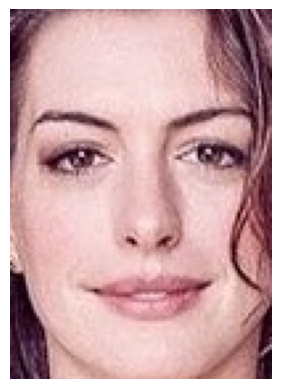

In [36]:
from mtcnn import MTCNN
import cv2
import os

detector = MTCNN()

def detectar_rosto(caminho_imagem):
    imagem = cv2.imread(caminho_imagem)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(imagem)

    if len(faces) > 0:
        x, y, largura, altura = faces[0]['box']
        rosto = imagem[y:y+altura, x:x+largura]
        return rosto
    else:
        return None

caminho_teste = "/content/dataset_pins/105_classes_pins_dataset/pins_Anne Hathaway/Anne Hathaway10_295.jpg"  # Altere para um caminho válido
rosto_detectado = detectar_rosto(caminho_teste)

if rosto_detectado is not None:
    import matplotlib.pyplot as plt
    plt.imshow(rosto_detectado)
    plt.axis("off")
    plt.show()
else:
    print("Nenhum rosto detectado.")


In [28]:
!pip install keras_facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=e30b47b6e1d643547eede069515ee833a264dca3ea465264f08cb235769a43cf
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras_facenet


In [ ]:
from keras_facenet import FaceNet
from mtcnn import MTCNN
from sklearn.svm import OneClassSVM
import numpy as np
import cv2
import os

embedder = FaceNet()
detector = MTCNN()

def detectar_rosto(caminho_imagem):
    try:
        img = cv2.imread(caminho_imagem)
        if img is None:
            print(f"Erro: Imagem não encontrada em {caminho_imagem}")
            return None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resultados = detector.detect_faces(img_rgb)

        if not resultados:
            return None

        maior_rosto = sorted(resultados, key=lambda x: x['box'][2] * x['box'][3], reverse=True)[0]
        x, y, w, h = maior_rosto['box']
        x, y = abs(x), abs(y)
        return img_rgb[y:y+h, x:x+w]

    except Exception as e:
        print(f"Erro ao processar {caminho_imagem}: {str(e)}")
        return None

def criar_embeddings(pasta_dataset):
    embeddings = []

    # Caminho específico pra Anne Hathaway
    pasta_base = os.path.join(pasta_dataset, "105_classes_pins_dataset")
    pasta_alvo = os.path.join(pasta_base, "pins_Anne Hathaway")

    if not os.path.exists(pasta_alvo):
        print(f"ERRO: Pasta não encontrada - {pasta_alvo}")
        return np.array([])

    print(f"Processando apenas: Anne Hathaway")

    for arquivo in os.listdir(pasta_alvo):
        if not arquivo.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        caminho_imagem = os.path.join(pasta_alvo, arquivo)

        rosto = detectar_rosto(caminho_imagem)
        if rosto is not None:
            try:
                rosto = cv2.resize(rosto, (160, 160)).astype('float32')
                embedding = embedder.embeddings([rosto])[0]
                embeddings.append(embedding)
            except Exception as e:
                print(f"Erro no arquivo {arquivo}: {str(e)}")

    return np.array(embeddings)

X_train = criar_embeddings("/content/dataset_pins")

if len(X_train) > 0:
    modelo = OneClassSVM(kernel='rbf', gamma='auto')
    modelo.fit(X_train)
    print("Modelo treinado com sucesso!")

    # Testando com imagem específica
    caminho_teste = "/content/dataset_pins/105_classes_pins_dataset/pins_Anne Hathaway/Anne Hathaway105_300.jpg"
    rosto_teste = detectar_rosto(caminho_teste)

    if rosto_teste is not None:
        rosto_teste = cv2.resize(rosto_teste, (160, 160)).astype('float32')
        embedding_teste = embedder.embeddings([rosto_teste])[0]
        predicao = modelo.predict([embedding_teste])
        print(f"Resultado: {'Anne Hathaway' if predicao[0] == 1 else 'Não reconhecido'}")
    else:
        print("Nenhum rosto detectado na imagem de teste")
else:
    print("Erro: Nenhum dado foi processado")


Processando apenas: Anne Hathaway
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


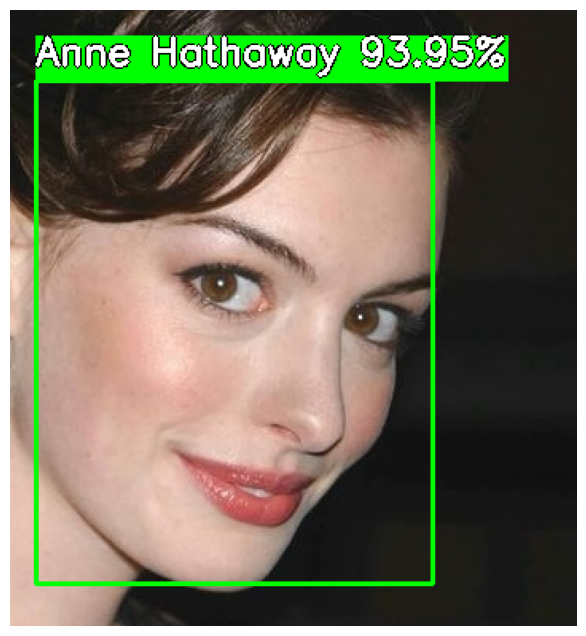

In [43]:
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

media_embeddings = np.mean(X_train, axis=0)

def calcular_confianca(embedding_teste):
    similaridade = cosine_similarity([embedding_teste], [media_embeddings])[0][0]
    confianca = max(0, min(100, (similaridade + 1) * 50))  # Converte de [-1,1] para [0,100]
    return confianca

def detectar_e_classificar(caminho_imagem, modelo, embedder, detector):
    img = cv2.imread(caminho_imagem)
    if img is None:
        print(f"Erro: Imagem não encontrada em {caminho_imagem}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_plot = img_rgb.copy()

    resultados = detector.detect_faces(img_rgb)

    if not resultados:
        print("Nenhum rosto detectado")
        return None

    for face in resultados:
        x, y, w, h = face['box']
        x, y = abs(x), abs(y)

        try:
            rosto = img_rgb[y:y+h, x:x+w]
            rosto_pp = cv2.resize(rosto, (160, 160)).astype('float32')
            embedding = embedder.embeddings([rosto_pp])[0]

            predicao = modelo.predict([embedding])[0]
            confianca = calcular_confianca(embedding)

            cor = (0, 255, 0) if predicao == 1 else (255, 0, 0)
            texto = f"Anne Hathaway {confianca:.2f}%" if predicao == 1 else "Desconhecido"

            cv2.rectangle(img_plot, (x, y), (x+w, y+h), cor, 2)

            (text_width, text_height), _ = cv2.getTextSize(texto, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            cv2.rectangle(img_plot, (x, y - text_height - 10), (x + text_width, y), cor, -1)

            cv2.putText(img_plot, texto, (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 3)
            cv2.putText(img_plot, texto, (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

        except Exception as e:
            print(f"Erro no processamento: {str(e)}")

    return img_plot

caminho_teste = "/content/dataset_pins/105_classes_pins_dataset/pins_Anne Hathaway/Anne Hathaway128_321.jpg"
resultado_plot = detectar_e_classificar(caminho_teste, modelo, embedder, detector)

if resultado_plot is not None:
    plt.figure(figsize=(12, 8))
    plt.imshow(resultado_plot)
    plt.axis('off')
    plt.show()
else:
    print("Nenhum resultado para exibir")
